In [4]:
# Load libraries
import numpy as np
from tensorflow.keras.applications import vgg16
from tensorflow.keras.layers import Dense, Flatten, Dropout, GlobalAveragePooling2D, Reshape, multiply, Add, Activation
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers.legacy import Adam
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split
from PIL import Image
import os

In [5]:


# Function to load and preprocess the dataset
def load_preprocessed_dataset(fname):
    # Load the dataset
    data = np.genfromtxt(fname, dtype=['|S19', '<f8', '|S4'], names=[
                         'path', 'probability', 'type'])
    image_fnames = np.char.decode(data['path'])
    probs = data['probability']
    types = np.char.decode(data['type'])

    # Define a function to preprocess the images
    def load_and_preprocess_image(fname):
        with Image.open(fname) as image:
            # Preprocess image for VGG-16
            image = image.convert('RGB')
            image = image.resize((224, 224))
            image = np.array(image)
            image = vgg16.preprocess_input(image)
            return image
    
    # Load and preprocess images
    dir = os.path.dirname(fname)
    images = np.array([load_and_preprocess_image(os.path.join(dir, fn))
                       for fn in image_fnames])
    
    # Convert probabilities to categorical labels
    labels = to_categorical(probs * 3, num_classes=4)
    
    return images, labels, types

# Load the dataset
images, labels, types = load_preprocessed_dataset('elpv-dataset/labels.csv')

# Split the dataset into training and testing
X_train, X_test, y_train, y_test = train_test_split(images, labels, test_size=0.2, random_state=42)

# Load the VGG-16 model
base_model = vgg16.VGG16(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Freeze the layers of the base model
for layer in base_model.layers:
    layer.trainable = False

# Add custom layers on top of the base model
x = Flatten()(base_model.output)
x = Dense(256, activation='relu')(x)
x = Dropout(0.5)(x)
predictions = Dense(4, activation='softmax')(x)

# Create the final model
model = Model(inputs=base_model.input, outputs=predictions)

# Compile the model
model.compile(optimizer=Adam(learning_rate=0.0001), loss='categorical_crossentropy', metrics=['accuracy'])

# Train the model
history = model.fit(X_train, y_train, epochs=5, batch_size=32, validation_data=(X_test, y_test))


Epoch 1/5
66/66 [==============================] - 216s 3s/step - loss: 1.7787 - accuracy: 0.6036 - val_loss: 0.8134 - val_accuracy: 0.7390
Epoch 2/5
66/66 [==============================] - 211s 3s/step - loss: 0.7749 - accuracy: 0.7203 - val_loss: 0.7620 - val_accuracy: 0.7371
Epoch 3/5
66/66 [==============================] - 170s 3s/step - loss: 0.6730 - accuracy: 0.7470 - val_loss: 0.7648 - val_accuracy: 0.7238
Epoch 4/5
66/66 [==============================] - 132s 2s/step - loss: 0.5776 - accuracy: 0.7856 - val_loss: 0.7210 - val_accuracy: 0.7619
Epoch 5/5
66/66 [==============================] - 136s 2s/step - loss: 0.5358 - accuracy: 0.8013 - val_loss: 0.7190 - val_accuracy: 0.7505


In [7]:
from sklearn.metrics import confusion_matrix, classification_report
import numpy as np

# Predict the test set results
y_pred = model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)

# Convert y_test from one-hot encoding to class indices
y_test_classes = np.argmax(y_test, axis=1)

# Now calculate the confusion matrix
cm = confusion_matrix(y_test_classes, y_pred_classes)
print("Confusion Matrix:")
print(cm)

# Similarly, adjust the classification report
report = classification_report(y_test_classes, y_pred_classes, target_names=['Fully Functional', 'Possibly Defective', 'Likely Defective', 'Certainly Defective'])
print("\nClassification Report:")
print(report)



17/17 [==============================] - 28s 2s/step
Confusion Matrix:
[[276   9   0  21]
 [ 37  19   0   2]
 [ 17   2   0   3]
 [ 32   6   2  99]]

Classification Report:
                     precision    recall  f1-score   support

   Fully Functional       0.76      0.90      0.83       306
 Possibly Defective       0.53      0.33      0.40        58
   Likely Defective       0.00      0.00      0.00        22
Certainly Defective       0.79      0.71      0.75       139

           accuracy                           0.75       525
          macro avg       0.52      0.49      0.50       525
       weighted avg       0.71      0.75      0.72       525



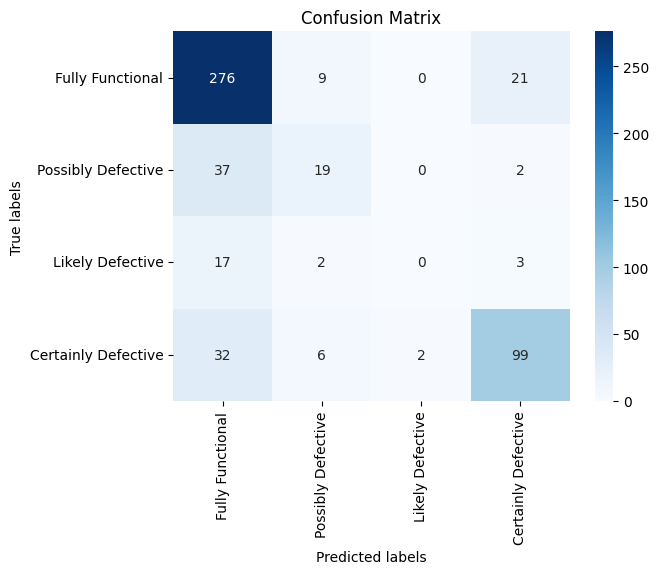

In [8]:
import matplotlib.pyplot as plt
import seaborn as sns

sns.heatmap(cm, annot=True, fmt='g', cmap='Blues', xticklabels=['Fully Functional', 'Possibly Defective', 'Likely Defective', 'Certainly Defective'], yticklabels=['Fully Functional', 'Possibly Defective', 'Likely Defective', 'Certainly Defective'])
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix')
plt.show()


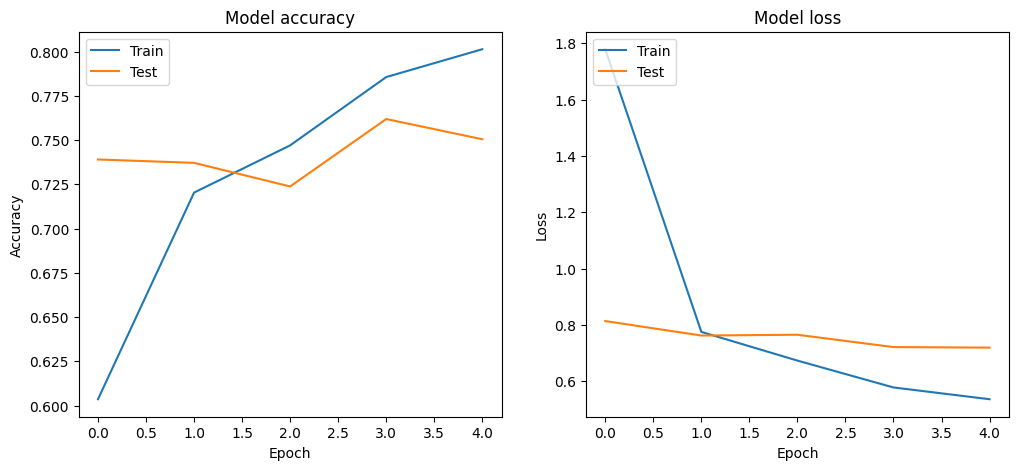

In [9]:
# Plot training & validation accuracy values
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')

# Plot training & validation loss values
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()


In [12]:
from sklearn.metrics import classification_report
import pandas as pd
# Convert y_test from one-hot encoding to class indices
y_test_classes = np.argmax(y_test, axis=1)

# Generate the classification report
report = classification_report(y_test_classes, y_pred_classes, target_names=['Fully Functional', 'Possibly Defective', 'Likely Defective', 'Certainly Defective'], output_dict=True)

# Convert to DataFrame
report_df = pd.DataFrame(report).transpose()

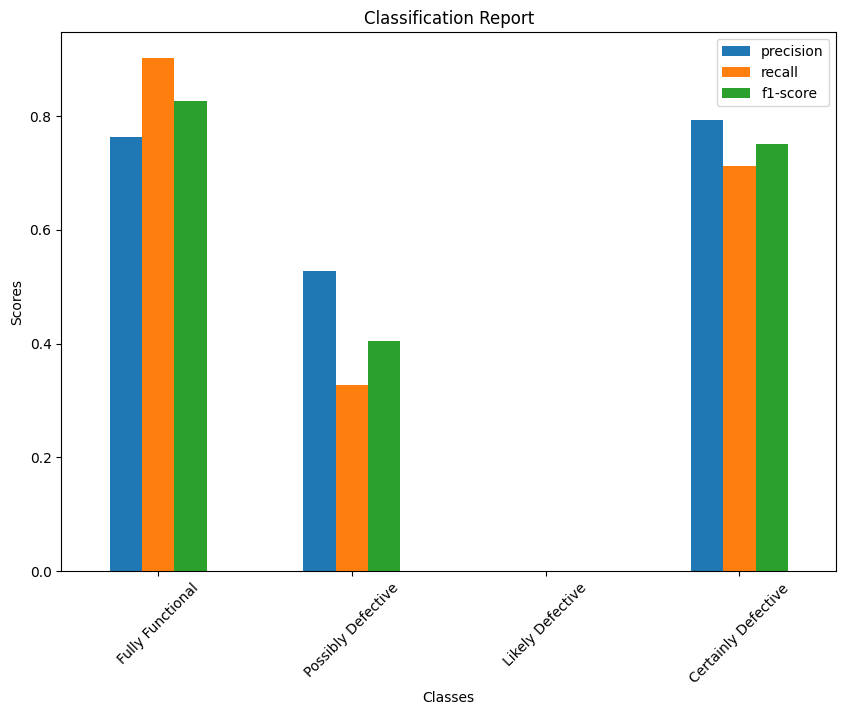

In [13]:
# Drop the support row
report_df = report_df.drop('support', axis=1)

# Plotting
report_df[:-3].plot(kind='bar', figsize=(10, 7))
plt.title('Classification Report')
plt.xlabel('Classes')
plt.ylabel('Scores')
plt.xticks(rotation=45)
plt.show()
